<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/SeungTaek/two_stage_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 16.1 MB/s 
     |████████████████████████████████| 596 kB 70.5 MB/s 
     |████████████████████████████████| 67 kB 7.5 MB/s 
     |████████████████████████████████| 895 kB 85.3 MB/s 
     |████████████████████████████████| 6.5 MB 62.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [70]:
import pandas as pd # pandas 모듈 로드
import json  # json 모듈 로드
import re
import os
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import sklearn
from collections import defaultdict, Counter
from google.colab import drive

#from keras.preprocessing.sequence import pad_sequences
#import tensorflow as tf
#from transformers import TextClassificationPipeline
from transformers import BertTokenizer, TFBertModel   #BERT
#from tensorflow.keras.layers import Dense, Flatten

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -uq "/content/drive/MyDrive/AIFFEL/sns_train.zip" -d "/content/sns_data"

In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/AIFFEL/train/train.csv")

In [6]:
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [7]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣0-9]+", " ", sentence)
    #sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,\n]+", " ", sentence)
    #sentence = re.sub('\n'," "+"\n"+" ",sentence)

    sentence = sentence.strip()

    return sentence

In [8]:
train_df["conversation"] = train_df["conversation"].apply(preprocess_sentence)
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐 내 머리가 뭐 밥먹으면 대가리만 크냐 너는 아니 ...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어 살리고 싶으면 계좌에 1억만 보내 예 선생님...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라 어떻게 저렇게 살지 왜 그래 들리겠어 들리라...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래 이게 무슨일입니까 남의 구역에서 장사하려면 자릿세를 내야...


In [9]:
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()
    
    print("< Sentence Info >".center(100, "="))
    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.3f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.3f}", end="\n\n")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")
    print("=" * 100)

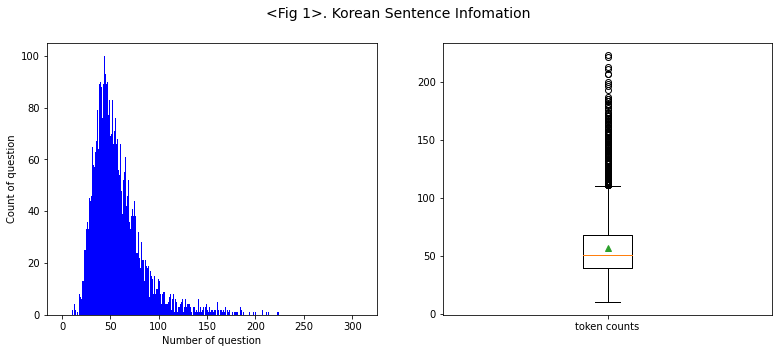

=========================================< Sentence Info >==========================================
길이 최대:     223
길이 최소:      10
길이 평균:     57.330
길이 표준편차:  27.040

 25/100분위:   40.000
 50/100분위:   51.000
 75/100분위:   68.000
 MAX/100분위: 110.000
 IQR:  28.000


In [10]:
sentence_counts = [len(text.split()) for text in train_df["conversation"]]

show_sentence_length(sentence_counts, "<Fig 1>. Korean Sentence Infomation", [0, 310])

In [11]:
data_path ="/content/sns_data/content/sns_csv_train"
files = glob(data_path + "/*")
files

['/content/sns_data/content/sns_csv_train/미용과건강.csv',
 '/content/sns_data/content/sns_csv_train/여가생활.csv',
 '/content/sns_data/content/sns_csv_train/시사교육.csv',
 '/content/sns_data/content/sns_csv_train/상거래(쇼핑).csv',
 '/content/sns_data/content/sns_csv_train/일과직업.csv',
 '/content/sns_data/content/sns_csv_train/행사.csv',
 '/content/sns_data/content/sns_csv_train/식음료.csv',
 '/content/sns_data/content/sns_csv_train/개인및관계.csv',
 '/content/sns_data/content/sns_csv_train/주거와생활.csv']

In [12]:

df_all = pd.DataFrame()
for i in files:
    df = pd.read_csv(i)
    df_all = pd.concat([df_all, df])


In [13]:
df_all["class"] = "일반 대화"

In [14]:
df_all.head()

,0,class
0,아니 나도 이제야 목이아프기시작햇어 침삼키는게 왜케아프죸ㅋㅋㅋㅋㅋㅋㅋ\n나듀 난 이...,일반 대화
1,배아퍼서 화장실왓는데 ㄷ우너유ㅠㅠ\n헐랭 배아포? ㅠㅠ\n웅 어제 계속 매운거만 먹...,일반 대화
2,나 요번주 금욜에 인생 최초로 위내시경 한다\n오우 함 해야해....! 화이또야 혼...,일반 대화
3,자거일어남ㄴ 왤케 담이 심해질따 까\n잘때 어찌자노\n편하게...자눈데...\n너무...,일반 대화
4,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ운동이고 뭐고 이불 속이 최고시더\n나두 운동해야될것같은데 ㅠㅠ...,일반 대화


In [15]:
df_all = df_all.rename(columns = {'0' : "conversation"})

In [16]:
df_all = df_all[['class', 'conversation']]
df_all

,class,conversation
0,일반 대화,아니 나도 이제야 목이아프기시작햇어 침삼키는게 왜케아프죸ㅋㅋㅋㅋㅋㅋㅋ\n나듀 난 이...
1,일반 대화,배아퍼서 화장실왓는데 ㄷ우너유ㅠㅠ\n헐랭 배아포? ㅠㅠ\n웅 어제 계속 매운거만 먹...
2,일반 대화,나 요번주 금욜에 인생 최초로 위내시경 한다\n오우 함 해야해....! 화이또야 혼...
3,일반 대화,자거일어남ㄴ 왤케 담이 심해질따 까\n잘때 어찌자노\n편하게...자눈데...\n너무...
4,일반 대화,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ운동이고 뭐고 이불 속이 최고시더\n나두 운동해야될것같은데 ㅠㅠ...
...,...,...
197539,일반 대화,6일부터 재난지원금신청할수있대\n응\n이번에는 개별적으로 다 신청한가보던데? 세대주...
197540,일반 대화,기대한다 차안에서 #@이름#랑 계속 물어본다 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ\n그만해\n왱\n...
197541,일반 대화,너는 독립 생각 엄써? 결혼전에\n완전많아 완.전. 나는진짜 너무하고싶어!!!!!!...
197542,일반 대화,차가 구려서 그런가 할튼 왕복 5시간넘게걸린듯\nㅎㅎㅎㅎ 너차 전혀 안구림 그정도 ...


In [17]:
df_train2 = df_all.sample(n = 4000, random_state = 6)

In [18]:
df_train2["conversation"] = df_train2["conversation"].apply(preprocess_sentence)
df_train2

,class,conversation
80023,일반 대화,평생 먹는 립스틱양을 믿어 평생 먹는 립스틱양이 얼마인데 여자는 평생 6개는 먹는다...
77587,일반 대화,시인과 농부 거기 카페 행궁동인가 어어 맞아 근데 정확히 남문이야 아하 행궁동이긴 ...
180182,일반 대화,9시까지 갈수있을까 아저씨가겁나달려주신다는데 차막히면노답인데 사고조심해주세요 아저씨...
50941,일반 대화,오빠 오늘 섹션투 잘 끝냈음 아 나 오늘 자기 전에 끝내야 할 듯 퓨 피드백 못 받...
94112,일반 대화,얼마나 휴가냈내 일단 3일 근육이 펑 터지는 소리남 신기하더라 안아픔 기타 아파 못...
...,...,...
277569,일반 대화,설기 하트가드 언제먹였었지 8월달에 사왔었지 저번에 언제였지 8월 15일에 삿엇음 ...
143485,일반 대화,냉면먹고싶다 또 옹옹 원래 나 냉면 짱 좋아해 근데 배탈이 너무 잘나서 잘 안먹었쥐...
27563,일반 대화,이름 도 낼 갈래 나는 내일 고양이보러갈거야 그려 웅 누구 고양이보러가 이름 네 고...
129107,일반 대화,주소좀알려줘봐 미리 바꿔놓게 아오 주소 찾는중 아니 엄마가 갠톡으로 안보내고 단톡에...


In [19]:
df_train2.to_csv("/content/drive/MyDrive/AIFFEL/sns_4000.csv")

In [20]:
df_train2.describe()

,class,conversation
count,4000,4000
unique,1,4000
top,일반 대화,평생 먹는 립스틱양을 믿어 평생 먹는 립스틱양이 얼마인데 여자는 평생 6개는 먹는다...
freq,4000,1


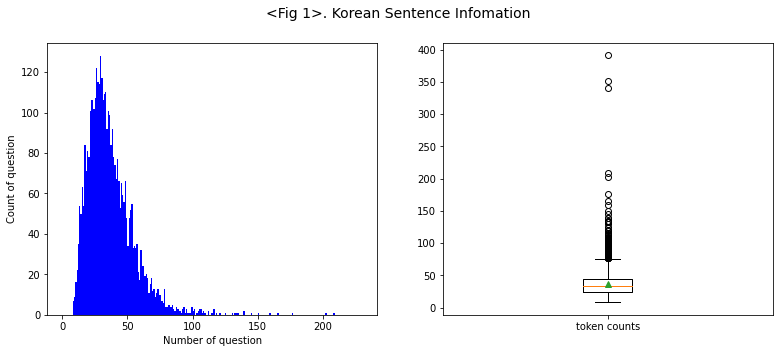

=========================================< Sentence Info >==========================================
길이 최대:     391
길이 최소:       8
길이 평균:     36.830
길이 표준편차:  20.485

 25/100분위:   24.000
 50/100분위:   33.000
 75/100분위:   45.000
 MAX/100분위:  76.500
 IQR:  21.000


In [21]:
sentence_counts_2 = [len(text.split()) for text in df_train2["conversation"]]

show_sentence_length(sentence_counts_2, "<Fig 1>. Korean Sentence Infomation", [0, 230])

In [22]:
df_train = pd.concat([train_df, df_train2])
df_train

,idx,class,conversation
0,0.0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1.0,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2.0,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3.0,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4.0,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
277569,NaN,일반 대화,설기 하트가드 언제먹였었지 8월달에 사왔었지 저번에 언제였지 8월 15일에 삿엇음 ...
143485,NaN,일반 대화,냉면먹고싶다 또 옹옹 원래 나 냉면 짱 좋아해 근데 배탈이 너무 잘나서 잘 안먹었쥐...
27563,NaN,일반 대화,이름 도 낼 갈래 나는 내일 고양이보러갈거야 그려 웅 누구 고양이보러가 이름 네 고...
129107,NaN,일반 대화,주소좀알려줘봐 미리 바꿔놓게 아오 주소 찾는중 아니 엄마가 갠톡으로 안보내고 단톡에...


In [23]:
df_train = df_train.drop(['idx'],axis=1)
df_train

,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...
277569,일반 대화,설기 하트가드 언제먹였었지 8월달에 사왔었지 저번에 언제였지 8월 15일에 삿엇음 ...
143485,일반 대화,냉면먹고싶다 또 옹옹 원래 나 냉면 짱 좋아해 근데 배탈이 너무 잘나서 잘 안먹었쥐...
27563,일반 대화,이름 도 낼 갈래 나는 내일 고양이보러갈거야 그려 웅 누구 고양이보러가 이름 네 고...
129107,일반 대화,주소좀알려줘봐 미리 바꿔놓게 아오 주소 찾는중 아니 엄마가 갠톡으로 안보내고 단톡에...


In [24]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,class,conversation
0,일반 대화,야 상식적으로 내일 나 아침에 태워주기로 햇으면 적어도 오늘 나한테 한마디는 해줘야...
1,일반 대화,희한하게라고한건 희한하게 오늘따라 꿈이 기억 안 난다는게 인지하고 생각됐는데 너는 ...
2,일반 대화,마산에 잘다녀왕 사랑해여 나두 사랑해염 금방 다녀와 금방다녀올게 나 버스 출발한닷 ...
3,갈취 대화,그 반지 멋진걸 안돼요 이리 내 어서 이건 결혼 반지입니다 내놓지 못해 안돼요 돈을...
4,일반 대화,우리머머거 초밥 애기 초밥 먹고시포 아님 보쌈 나도초밥도먹곳 다 다먹고싶으면 어케 ...
...,...,...
7945,일반 대화,이름 지금 배고파서 당장 먹구싶댜 이름 어늘 모랭 어제 데자뷰가 공부 이제 이주동안...
7946,협박 대화,오늘도 윗집은 축구하나보다 어휴 오늘 또 잠 다 잤구나 경비실에 전화해야겠다 경비아...
7947,갈취 대화,조용히해 고개 돌리지마 니 뒤에 닿은거 칼이거든 생각 잘해 누구세요 뭍지마 뭍는말에...
7948,일반 대화,나도 나가는 길에 인절미 초코파이 시왔다 먹어봤나 어 에어프라이긴 아직안돌림 괜춘 ...


In [25]:
df = pd.read_csv("/content/drive/MyDrive/AIFFEL/senti_kor_sns_5000_bt.csv")
df.head()

,Unnamed: 0,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,0,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,3,1,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [26]:
bucket_class = []
label_names = ["협박 대화", "갈취 대화", "직장 내 괴롭힘 대화", 
               "기타 괴롭힘 대화", "일반 대화"]

for idx, label in enumerate(df["class"]):
  if label == 0:
    bucket_class.append(label_names[0])
  elif label == 1:
    bucket_class.append(label_names[1])
  elif label == 2:
    bucket_class.append(label_names[2])
  elif label == 3:
    bucket_class.append(label_names[3])
  elif label == 4:
    bucket_class.append(label_names[4])

df["class"] = bucket_class
df.head()

,Unnamed: 0,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


협박 대화           3924
갈취 대화           4376
직장 내 괴롭힘 대화    15346
기타 괴롭힘 대화       3916
일반 대화           3584
Name: Unnamed: 0, dtype: int64


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_

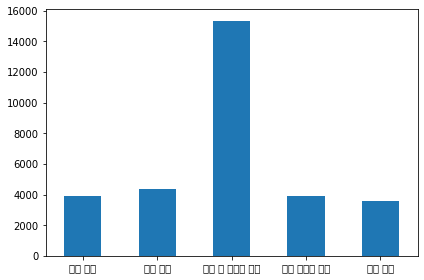

In [27]:
group_count = df.groupby("class").count().iloc[:,0]
group_count.index = label_names
print(group_count)
group_count.plot(kind="bar")
plt.xticks(rotation = 360)
plt.tight_layout()
plt.show()

In [28]:
bucket_class.count("일반 대화")

15346

In [29]:
df_train = df

In [30]:
def filt_sentence_length(df, col, sentence_len):
    df = df.copy()
    df["len"] = df[col].apply(lambda x: len(x.split()))
    df = df.loc[df["len"] < sentence_len]
    df.drop(["len"], axis="columns", inplace=True)
    return df
    
dataset = filt_sentence_length(df_train, "conversation", 128)

In [31]:
df_train["협박 대화"] = int(0)
df_train["갈취 대화"] = int(0)
df_train["직장 내 괴롭힘 대화"] = int(0)
df_train["기타 괴롭힘 대화"] = int(0)
df_train["일반 대화"] = int(0)
df_train.head()

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,0,0,0,0,0
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,0,0,0,0,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,0,0,0,0,0
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,0,0,0,0,0
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0,0,0,0,0


In [32]:
for idx, label in enumerate(df_train["class"]):
    if label == "협박 대화":
        df_train.loc[idx, "협박 대화"] = int(1)
    elif label == "갈취 대화":
        df_train.loc[idx, "갈취 대화"] = int(1)
    elif label == "직장 내 괴롭힘 대화":
        df_train.loc[idx, "직장 내 괴롭힘 대화"] = int(1)
    elif label == "기타 괴롭힘 대화":
        df_train.loc[idx, "기타 괴롭힘 대화"] = int(1)
    elif label == "일반 대화":
        df_train.loc[idx, "일반 대화"] = int(1)
df_train.head()

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,1,0,0,0,0
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,1,0,0,0,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,0,0,0,1,0
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,0,1,0,0,0
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0,1,0,0,0


In [33]:
df_train

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,1,0,0,0,0
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,1,0,0,0,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,0,0,0,1,0
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,0,1,0,0,0
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0,1,0,0,0
...,...,...,...,...,...,...,...,...
31141,31141,기타 괴롭힘 대화,"준샤, 왜 이렇게 큰 거야? 내 머릿속에 뭐가 들어있어? 큰 사람이라고 말하지 않았...",0,0,0,1,0
31142,31142,갈취 대화,"내가 지금 당신 아들을 데리고 있다면, 당신이 그를 구하려고 하면, 그냥 돈을 보내...",0,1,0,0,0
31143,31143,직장 내 괴롭힘 대화,당신 같은 사람을 보면 어떻게 이렇게 살 수 있을까요? 왜 그렇게 말하는 거죠? 지...,0,0,1,0,0
31144,31144,갈취 대화,"여기서 무슨 일을 하든 경찰에 신고하고 정식으로 사업을 해야 하는데, 어디든 우리 ...",0,1,0,0,0


In [34]:
group_count = df_train.groupby("class").count().iloc[:,0]
group_count

class
갈취 대화           3924
기타 괴롭힘 대화       4376
일반 대화          15346
직장 내 괴롭힘 대화     3916
협박 대화           3584
Name: Unnamed: 0, dtype: int64

In [35]:
number_min_label = min(group_count)
print(f"레이블중에서 가장 개수가 작은 레이블의 개수 : {number_min_label}")

레이블중에서 가장 개수가 작은 레이블의 개수 : 3584


In [36]:
under_train = df_train.groupby("class").sample(number_min_label, random_state = 5)
under_train.groupby("class").count().iloc[:,0]

class
갈취 대화          3584
기타 괴롭힘 대화      3584
일반 대화          3584
직장 내 괴롭힘 대화    3584
협박 대화          3584
Name: Unnamed: 0, dtype: int64

In [37]:
df_train = under_train
df_train

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
30257,30257,갈취 대화,내가 선물한 거 맞아 네 생일 선물 가장 중요한 사람을 받았는데 그냥 좀 줘,0,1,0,0,0
29668,29668,갈취 대화,"미안해요, 돈을 못 받았어요 죄송해요 그냥 말씀드렸는데 용기가 없어요 뭐라고 말씀하...",0,1,0,0,0
22712,22712,갈취 대화,"당신 한 사람당 오늘 얼마를 받았는지 아, 30만 원을 받았습니다. 제가 당신이 생...",0,1,0,0,0
31068,31068,갈취 대화,"미안해요, 아버지가 잠을 자지 않았어요 안 가져왔어요 우리가 해야 할 일은 아주 잘...",0,1,0,0,0
27443,27443,갈취 대화,"내가 매일 5만 달러를 벌어야 하는 이유가 뭐야? 미안해, 돈이 없으면 이 해에 모...",0,1,0,0,0
...,...,...,...,...,...,...,...,...
24230,24230,협박 대화,언제 갚을 건데? 내가 곧 갚을 것을 기다릴 수는 없다 반납하기로 한 지 벌써 3개...,1,0,0,0,0
23474,23474,협박 대화,"네가 말하는 정보가 있어. 힘든 일을 위해 그렇게 말했던 것은 그것뿐이지만, 이 일...",1,0,0,0,0
21888,21888,협박 대화,"당장 세금을 안내해 드리면 이를 제거해 버릴 거예요. 그래, 모르겠어요. 귀찮아서 ...",1,0,0,0,0
23743,23743,협박 대화,눈으로 운전하고 있었기 때문에 사고를 당할 생각은 아니었지만 믿을 수 없어서 미안해...,1,0,0,0,0


In [38]:
target_col= df_train.columns[3:]
feature_col= df_train.columns[2:3]
df_train.head()

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
30257,30257,갈취 대화,내가 선물한 거 맞아 네 생일 선물 가장 중요한 사람을 받았는데 그냥 좀 줘,0,1,0,0,0
29668,29668,갈취 대화,"미안해요, 돈을 못 받았어요 죄송해요 그냥 말씀드렸는데 용기가 없어요 뭐라고 말씀하...",0,1,0,0,0
22712,22712,갈취 대화,"당신 한 사람당 오늘 얼마를 받았는지 아, 30만 원을 받았습니다. 제가 당신이 생...",0,1,0,0,0
31068,31068,갈취 대화,"미안해요, 아버지가 잠을 자지 않았어요 안 가져왔어요 우리가 해야 할 일은 아주 잘...",0,1,0,0,0
27443,27443,갈취 대화,"내가 매일 5만 달러를 벌어야 하는 이유가 뭐야? 미안해, 돈이 없으면 이 해에 모...",0,1,0,0,0


In [55]:
target_col

Index(['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화'], dtype='object')

In [71]:
proc_train_df = sklearn.utils.shuffle(df_train)
proc_train_df

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
799,799,협박 대화,오늘이 며칠인데 아직도 그걸 못 가져와? 한 달만 더 시간을 주세요. 딱 한 달만....,1,0,0,0,0
1845,1845,기타 괴롭힘 대화,여기 사장님 어디잇나요 ? 뭐때문에 그러시죠 ? 내가 한달전에 여기서 청소기를 샀는...,0,0,0,1,0
18415,18415,일반 대화,친구들에게 따돌림당했어. 친구들에게 따돌림을 당하셨다니 많이 힘드시겠어요. 응 너무...,0,0,0,0,1
22413,22413,기타 괴롭힘 대화,"야 친타운 가서 빵 좀 사서 지금 우리 우유처럼 돈은 니동에서 사서, 지금은 돈이 ...",0,0,0,1,0
27133,27133,직장 내 괴롭힘 대화,"박씨의 커피가 여기 있습니다. 아, 그래, 김인턴 감사합니다. 동시에 김인턴이 커피...",0,0,1,0,0
...,...,...,...,...,...,...,...,...
20396,20396,기타 괴롭힘 대화,너는 왜 옷을 그렇게 입고 왜 내 마음인데 너만 생각하고 있는 것 같으니까 내가 입...,0,0,0,1,0
27580,27580,갈취 대화,"내가 원하는 돈을 어디서 찾을 수 있는지 알려줬는데, 오늘 내가 가져올 거라고 말했...",0,1,0,0,0
401,401,갈취 대화,내가 분명히 요번주까지 돈 준비하라고 했지. 어떻게 된거야. 죄송합니다. 다음주까지...,0,1,0,0,0
2476,2476,직장 내 괴롭힘 대화,박하선 일병 빠졌네 일병 박하선 야 불렀는데 대답안하냐? 죄송합니다 니 맞선임 누구...,0,0,1,0,0


In [40]:
#!pip install texthero
#!pip install tweet-preprocessor

In [72]:
from transformers import AutoTokenizer,TFDistilBertModel, DistilBertConfig
from transformers import TFAutoModel
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from transformers import AdamW, get_linear_schedule_with_warmup


#Creating tokenizer
def create_tokenizer(pretrained_weights="klue/bert-base"):
  '''Function to create the tokenizer'''

  tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
  return tokenizer

#Tokenization of the data
def data_tokenization(dataset,feature_col,max_len,tokenizer):
    '''dataset: Pandas dataframe with feature name is column name 
    Pretrained_weights: selected model 
    RETURN: [input_ids, attention_mask]'''

    tokens = dataset[feature_col].apply(lambda x: tokenizer(x,return_tensors='tf', 
                                                            truncation=True,
                                                            padding='max_length',
                                                            max_length=max_len, 
                                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)


    return [input_ids,attention_mask]

def bert_model(pretrained_weights,max_len,learning_rate):
  '''BERT model creation with pretrained weights
  INPUT:
  pretrained_weights: Language model pretrained weights
  max_len: input length '''
  print('Model selected:', pretrained_weights)
  bert=TFAutoModel.from_pretrained(pretrained_weights, from_pt=True)
  
  # This is must if you would like to train the layers of language models too.
  for layer in bert.layers:
      layer.trainable = True

  # parameter declaration
#   step = tf.Variable(0, trainable=False)
#   schedule = tf.optimizers.schedules.PiecewiseConstantDecay([10000, 15000], [2e-0, 2e-1, 1e-2])
#   # lr and wd can be a function or a tensor
#   lr = learning_rate * schedule(step)
#   wd = lambda:lr * schedule(step)
#   optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)

  optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
#   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # declaring inputs, BERT take input_ids and attention_mask as input
  input_ids= Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
  attention_mask=Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

  bert= bert(input_ids,attention_mask=attention_mask)
  x= bert[0][:,0,:]
  x=tf.keras.layers.Dropout(0.1)(x)
  x= tf.keras.layers.Dense(128)(x)
  x=tf.keras.layers.Dense(64)(x)
  x=tf.keras.layers.Dense(32)(x)

  output=tf.keras.layers.Dense(5,activation='sigmoid')(x)

  model=Model(inputs=[input_ids,attention_mask],outputs=[output])
  # compiling model 
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE,name='binary_crossentropy'),
                metrics=['accuracy'])
  return model

In [73]:
pretrained_weights="klue/bert-base"
max_len=128
epochs=3
learning_rate=2e-5
batch_size=4

In [74]:
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")

In [75]:
x_train= data_tokenization(proc_train_df,feature_col[0],max_len,tokenizer)

In [76]:
y_train= proc_train_df[target_col].values
y_train

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1]])

In [77]:
bert=bert_model(pretrained_weights,max_len,learning_rate)
bert.summary()

Model selected: klue/bert-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [78]:
with tf.device('/GPU:0'):
    bert.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4480/4480 [==============================] - 582s 128ms/step - loss: 0.1657 - accuracy: 0.8426
Epoch 2/3
4480/4480 [==============================] - 573s 128ms/step - loss: 0.0701 - accuracy: 0.9395
Epoch 3/3
4480/4480 [==============================] - 573s 128ms/step - loss: 0.0334 - accuracy: 0.9723


In [79]:
json_path = "/content/drive/MyDrive/AIFFEL/test/test.json"

df_test = pd.read_json(json_path, orient ='index')

In [80]:
df_test.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [84]:
x_test= data_tokenization(df_test,'text',max_len,tokenizer)

In [94]:
pred = bert.predict(x_test)
pred

array([[1.6992422e-05, 9.9847049e-01, 2.5356459e-04, 3.5749559e-04,
        1.6078311e-04],
       [2.9804321e-06, 1.6813703e-05, 9.9992931e-01, 2.4081501e-06,
        5.4243978e-05],
       [1.9809682e-05, 1.4005559e-04, 9.9985719e-01, 3.5108056e-05,
        4.0063311e-05],
       ...,
       [6.1373698e-06, 9.9963331e-01, 1.8486441e-03, 1.0677428e-04,
        1.0482741e-05],
       [3.1150562e-01, 6.7735962e-03, 7.1641266e-01, 3.2998720e-04,
        1.1370310e-04],
       [9.4870704e-01, 1.9360887e-02, 1.7751190e-05, 7.6281176e-06,
        7.3642796e-06]], dtype=float32)

In [95]:
pred = np.argmax(pred, axis = -1)
pred

array([1, 2, 2, 4, 4, 0, 0, 1, 4, 1, 0, 4, 2, 2, 2, 0, 4, 3, 0, 3, 0, 3,
       3, 1, 1, 2, 3, 4, 2, 1, 1, 0, 4, 1, 0, 3, 3, 1, 0, 1, 0, 1, 2, 1,
       4, 2, 0, 1, 4, 0, 1, 3, 1, 2, 2, 3, 3, 4, 3, 3, 1, 0, 0, 2, 2, 0,
       3, 0, 0, 1, 4, 2, 3, 2, 0, 4, 2, 1, 2, 4, 1, 0, 0, 1, 3, 2, 1, 4,
       1, 2, 2, 2, 0, 3, 3, 2, 1, 2, 1, 2, 1, 1, 4, 0, 3, 2, 2, 3, 3, 0,
       4, 0, 0, 2, 1, 1, 4, 2, 2, 1, 2, 3, 1, 1, 1, 1, 2, 4, 1, 3, 3, 3,
       2, 3, 1, 0, 3, 0, 3, 4, 0, 4, 1, 3, 2, 0, 0, 0, 3, 1, 0, 3, 0, 1,
       4, 4, 0, 2, 3, 3, 0, 3, 4, 0, 3, 3, 2, 4, 3, 1, 0, 2, 2, 3, 3, 3,
       2, 2, 1, 3, 2, 3, 2, 2, 0, 4, 4, 0, 1, 0, 0, 3, 1, 3, 1, 3, 0, 4,
       3, 1, 2, 0, 3, 1, 0, 3, 2, 2, 2, 2, 4, 1, 1, 2, 1, 4, 4, 4, 0, 0,
       1, 2, 0, 4, 1, 4, 1, 0, 1, 0, 2, 0, 3, 3, 1, 3, 3, 1, 0, 3, 3, 3,
       3, 2, 4, 1, 2, 3, 2, 1, 0, 3, 0, 2, 2, 1, 4, 2, 1, 2, 1, 1, 1, 3,
       4, 4, 3, 4, 1, 3, 1, 0, 0, 2, 1, 2, 2, 3, 2, 2, 1, 0, 3, 2, 4, 2,
       1, 2, 1, 3, 1, 1, 3, 3, 2, 0, 4, 0, 1, 0, 4,

In [87]:
pred_list = pred.tolist()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_

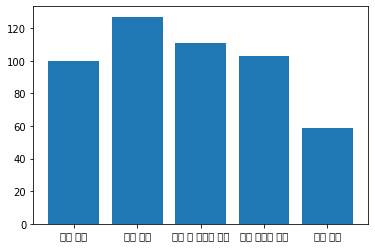

In [88]:
y = [pred_list.count(i) for i in range(5)]

plt.figure()
plt.bar(label_names, y)
plt.show()

In [89]:
pred_list.count(4)

59

In [91]:
bucket_text = []
with open("/content/drive/MyDrive/submission_0228_bert_valratio001_runmlm.json", "r") as f:
    data_dict = json.load(f)

In [92]:
b = []
for i,j in data_dict.items():
    b.append(int(j['class']))
np.array(b)

array([1, 2, 2, 4, 3, 0, 0, 1, 4, 1, 0, 4, 2, 2, 2, 0, 4, 4, 0, 3, 0, 3,
       3, 1, 1, 2, 3, 4, 2, 4, 1, 0, 2, 1, 0, 3, 3, 1, 0, 1, 0, 1, 2, 1,
       4, 2, 0, 0, 4, 0, 1, 3, 1, 2, 2, 3, 3, 4, 3, 3, 1, 3, 1, 3, 2, 0,
       3, 4, 4, 2, 4, 2, 3, 2, 0, 4, 2, 1, 2, 4, 1, 0, 4, 0, 3, 2, 0, 4,
       1, 2, 4, 2, 0, 3, 4, 2, 4, 2, 0, 0, 4, 1, 4, 0, 3, 2, 2, 3, 4, 0,
       4, 0, 0, 2, 1, 1, 4, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 4, 1, 4, 3, 3,
       2, 3, 1, 0, 3, 0, 4, 4, 3, 4, 1, 3, 2, 0, 0, 0, 0, 1, 0, 3, 4, 4,
       4, 4, 0, 2, 4, 3, 0, 3, 4, 0, 2, 4, 2, 4, 3, 1, 0, 2, 2, 3, 2, 3,
       0, 2, 1, 1, 2, 3, 2, 2, 0, 4, 4, 0, 1, 0, 0, 3, 1, 3, 1, 3, 0, 4,
       0, 0, 2, 0, 3, 3, 0, 3, 2, 1, 2, 2, 4, 3, 3, 2, 1, 4, 4, 4, 0, 0,
       1, 2, 0, 4, 0, 4, 1, 0, 1, 0, 2, 0, 0, 3, 1, 3, 3, 1, 0, 3, 3, 3,
       3, 2, 4, 1, 2, 3, 2, 0, 0, 4, 0, 2, 2, 1, 4, 2, 1, 2, 1, 4, 1, 3,
       4, 4, 3, 4, 4, 3, 1, 3, 0, 2, 4, 2, 2, 3, 2, 2, 1, 0, 3, 2, 4, 2,
       1, 2, 1, 3, 1, 1, 4, 3, 2, 3, 4, 4, 1, 0, 4,

In [96]:
from sklearn.metrics import classification_report

print(classification_report(np.array(b), pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       101
           1       0.81      0.95      0.88       108
           2       0.91      0.94      0.93       107
           3       0.82      0.85      0.83        99
           4       0.95      0.66      0.78        85

    accuracy                           0.86       500
   macro avg       0.87      0.85      0.85       500
weighted avg       0.87      0.86      0.86       500

